**Last Updated**: *7 May 2025*

**CNN Auto-Encoder**

In [2]:
# === Modules ===
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# === Load data ===
normal_data = np.load('train_non_CD_features2.npy')        
cd_data = np.load('train_CD_features2.npy')                

normal_data = np.delete(normal_data, [2, 3, 6], axis=1)
cd_data = np.delete(cd_data, [2, 3, 6], axis=1)

normal_tensor = torch.tensor(normal_data, dtype=torch.float32)
cd_tensor = torch.tensor(cd_data, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(normal_tensor), batch_size=32, shuffle=True)

In [4]:
# === Functions: Autoencoder ===
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), 
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(16, 4, kernel_size=3, stride=2, padding=1, output_padding=1),  
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x[:, :, :50, :50]


In [5]:
# === Set device ===
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device will run on {device}")

Device will run on cuda


In [6]:
# === Train the model ===
model = Autoencoder().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print("Training...")
for epoch in range(10):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs = batch[0].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.6f}")

Training...
Epoch 1: Loss = 0.411082
Epoch 2: Loss = 0.345426
Epoch 3: Loss = 0.343195
Epoch 4: Loss = 0.342288
Epoch 5: Loss = 0.341393
Epoch 6: Loss = 0.340774
Epoch 7: Loss = 0.340284
Epoch 8: Loss = 0.339824
Epoch 9: Loss = 0.339445
Epoch 10: Loss = 0.339202


In [7]:
# === Compute reconstruction error on CD data ===
model.eval()
with torch.no_grad():
    cd_tensor = cd_tensor.to(device)
    recon = model(cd_tensor)
    errors = torch.mean((cd_tensor - recon) ** 2, dim=[1, 2, 3]).cpu().numpy()

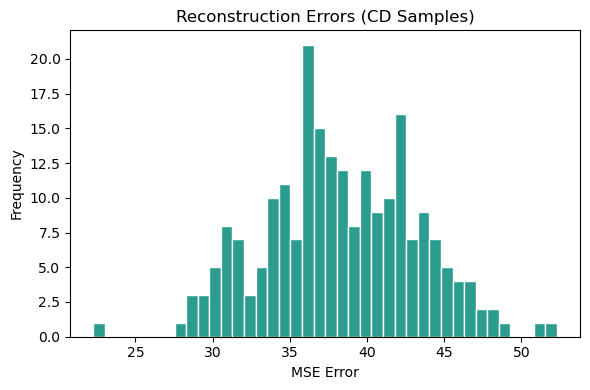

In [9]:
# === Plot error ===
plt.figure(figsize=(6, 4))
plt.hist(errors, bins=40, color='#2A9D8F', edgecolor='white')
plt.title("Reconstruction Errors (CD Samples)")
plt.xlabel("MSE Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
plt.close()


In [14]:
# ===Flag anomalies with threshold ===
threshold = np.percentile(errors, 50)
anomalies = errors > threshold
print(f"Threshold (95th percentile): {threshold:.6f}")
print(f"Detected {np.sum(anomalies)} anomalies out of {len(errors)} samples.")

Threshold (95th percentile): 37.979263
Detected 111 anomalies out of 223 samples.


In [16]:
unseen_data = np.load("test_CD_features2.npy")
unseen_data = np.delete(unseen_data, [2, 3, 6], axis=1)
unseen_tensor = torch.tensor(unseen_data, dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
    recon_unseen = model(unseen_tensor)
    errors_unseen = torch.mean((unseen_tensor - recon_unseen) ** 2, dim=[1, 2, 3]).cpu().numpy()

# Assume `threshold` was defined previously
anomalies = errors_unseen > threshold
print(f"Detected {np.sum(anomalies)} anomalies out of {len(errors_unseen)} samples.")

Detected 31 anomalies out of 68 samples.


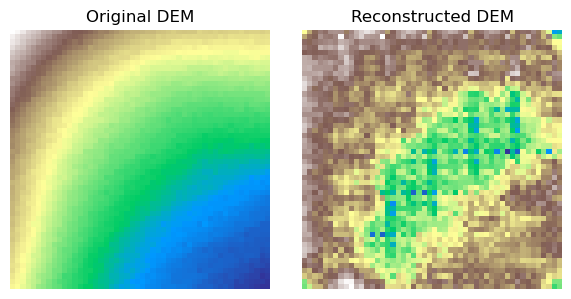

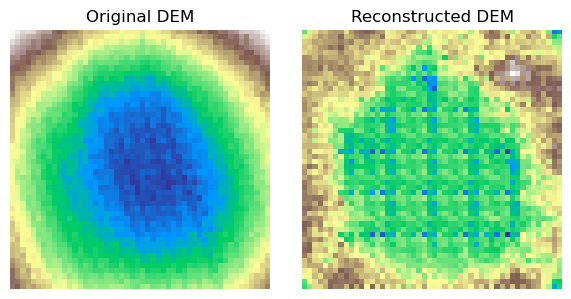

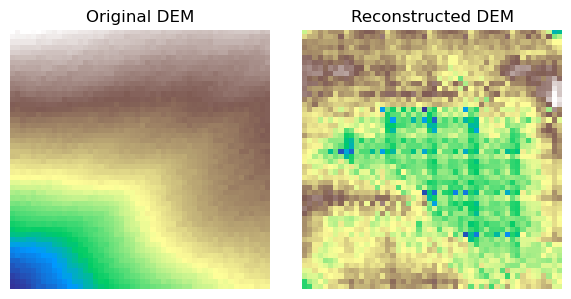

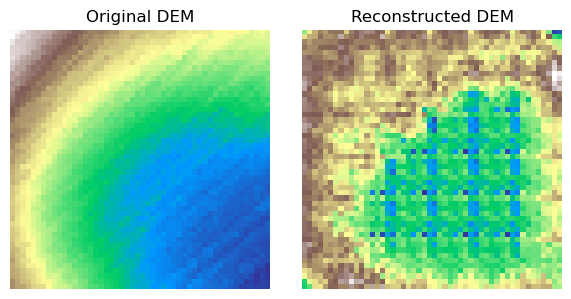

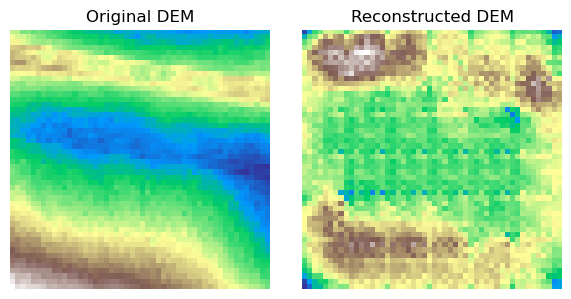

In [19]:
# === Plot examples ===
for i in np.where(anomalies)[0][:5]:
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    axes[0].imshow(unseen_tensor[i][0].cpu(), cmap='terrain')
    axes[0].set_title("Original DEM")
    axes[1].imshow(recon_unseen[i][0].cpu(), cmap='terrain')
    axes[1].set_title("Reconstructed DEM")
    for ax in axes: ax.axis('off')
    plt.tight_layout()
    plt.show()
    plt.close()